<a href="https://colab.research.google.com/github/Ferrari-coder/roadmapr-isolation-forest/blob/main/Roadmapr_Isolation_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import butter, filtfilt
import logging
from typing import List, Tuple, Dict


class RoadDataProcessor:
    def __init__(self,
                 epoch_duration: float = 2.0,
                 overlap: float = 0.5,
                 sampling_rate: int = 100):
        """
        Initialize the road data processor.

        Args:
            epoch_duration: Duration of each epoch in seconds
            overlap: Overlap between epochs (0.5 = 50%)
            sampling_rate: Expected sampling rate of the data in Hz
        """
        self.epoch_duration = epoch_duration
        self.overlap = overlap
        self.sampling_rate = sampling_rate
        self.setup_logging()

    def setup_logging(self):
        """Configure logging for the processor."""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)

    def load_csv_files(self, directory: str) -> Dict[str, pd.DataFrame]:
        """
        Load all CSV files from specified directory.

        Args:
            directory: Path to directory containing CSV files

        Returns:
            Dictionary mapping filenames to DataFrames
        """
        data_files = {}
        directory_path = Path(directory)

        try:
            # Get all CSV files in the directory
            csv_files = list(directory_path.glob('*.csv'))
            self.logger.info(f"Found {len(csv_files)} CSV files in {directory}")

            for file_path in csv_files:
                try:
                    # Read CSV file
                    df = pd.read_csv(file_path)
                    # Verify expected columns exist
                    required_columns = ['time', 'ax', 'ay', 'az', 'wx', 'wy', 'wz']
                    if not all(col in df.columns for col in required_columns):
                        self.logger.warning(f"Missing required columns in {file_path.name}")
                        continue

                    # Store DataFrame in the dictionary with filename (without extension) as key
                    data_files[file_path.stem] = df
                    self.logger.info(f"Loaded {file_path.name}: {len(df)} rows")

                except Exception as e:
                    self.logger.error(f"Error loading {file_path.name}: {str(e)}")

        except Exception as e:
            self.logger.error(f"Error accessing directory {directory}: {str(e)}")

        return data_files

    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Apply preprocessing steps to the data.

        Args:
            df: Input DataFrame with sensor readings

        Returns:
            Preprocessed DataFrame
        """
        # Create a copy to avoid modifying original data
        processed = df.copy()

        # Calculate magnitude of acceleration and angular velocity
        processed['acc_magnitude'] = np.sqrt(
            processed['ax'] ** 2 + processed['ay'] ** 2 + processed['az'] ** 2
        )
        processed['gyro_magnitude'] = np.sqrt(
            processed['wx'] ** 2 + processed['wy'] ** 2 + processed['wz'] ** 2
        )

        # Apply low-pass filter to remove high-frequency noise
        nyquist = self.sampling_rate * 0.5
        cutoff = 10  # 10 Hz cutoff frequency
        b, a = butter(4, cutoff / nyquist, btype='low')

        for col in ['ax', 'ay', 'az', 'acc_magnitude']:
            processed[f'{col}_filtered'] = filtfilt(b, a, processed[col])

        return processed

    def create_epochs(self, df: pd.DataFrame) -> List[Dict]:
        """
        Create overlapping epochs from the data.

        Args:
            df: Preprocessed DataFrame

        Returns:
            List of dictionaries containing epoch data and metadata
        """
        samples_per_epoch = int(self.epoch_duration * self.sampling_rate)
        stride = int(samples_per_epoch * (1 - self.overlap))
        epochs = []

        for i in range(0, len(df) - samples_per_epoch + 1, stride):
            epoch_data = df.iloc[i:i + samples_per_epoch]

            epoch = {
                'start_time': epoch_data['time'].iloc[0],
                'end_time': epoch_data['time'].iloc[-1],
                'data': epoch_data,
                'index': len(epochs)
            }

            epochs.append(epoch)

        self.logger.info(f"Created {len(epochs)} epochs")
        return epochs

    def process_file(self, df: pd.DataFrame, road_id: str) -> List[Dict]:
        """
        Process a single file's data into epochs.

        Args:
            df: Input DataFrame
            road_id: Identifier for the road/file

        Returns:
            List of processed epochs with metadata
        """
        # Preprocess the data
        processed_data = self.preprocess_data(df)

        # Create epochs
        epochs = self.create_epochs(processed_data)

        # Add road identifier to each epoch
        for epoch in epochs:
            epoch['road_id'] = road_id

        return epochs

    def process_all_files(self, directory: str) -> Tuple[List[Dict], Dict[str, int]]:
        """
        Process all CSV files in directory into epochs.

        Args:
            directory: Path to directory containing CSV files

        Returns:
            Tuple of (list of all epochs, dictionary of epochs per road)
        """
        data_files = self.load_csv_files(directory)
        all_epochs = []
        epochs_per_road = {}

        for road_id, df in data_files.items():
            road_epochs = self.process_file(df, road_id)
            all_epochs.extend(road_epochs)
            epochs_per_road[road_id] = len(road_epochs)

        self.logger.info(f"Total epochs created: {len(all_epochs)}")
        return all_epochs, epochs_per_road


def main():
    # Example usage
    processor = RoadDataProcessor(
        epoch_duration=2.0,
        overlap=0.5,
        sampling_rate=100
    )

    # Specify the directory where your CSV files are located
    directory_path = "drive/MyDrive/accelerometry/datasets"  # Update with the actual directory path

    # Process all files in the directory
    epochs, epochs_per_road = processor.process_all_files(directory_path)

    # Print summary of epochs created
    print("\nEpochs created per road:")
    for road_id, count in epochs_per_road.items():
        print(f"{road_id}: {count} epochs")

    # Optionally, return or further process the epochs for model input
    # Example: epochs could be saved or used in training an anomaly detection model

if __name__ == "__main__":
    main()



Epochs created per road:
Road 4 1: 59 epochs
Road 1a 2: 593 epochs
Road 2 3: 631 epochs
Road 2 2: 688 epochs
Road 2 1: 732 epochs
Road 1b 3: 547 epochs
Road 1a 3: 566 epochs
Road 1b 2: 527 epochs
Road 1b 1: 574 epochs
Road 1 a 1: 597 epochs
Road 5 3: 1212 epochs
Road 5 2: 333 epochs
Road 5 1: 320 epochs
Road 4 2 (1): 49 epochs
Road 4 2: 49 epochs
Road 4c: 49 epochs


In [ ]:
# Instantiate the data processor
processor = RoadDataProcessor(epoch_duration=2.0, overlap=0.5, sampling_rate=100)

# Specify the directory containing the CSV files
data_directory = 'drive/MyDrive/accelerometry/datasets'  # Update with your actual directory path

# Load all CSV files from the directory
data_files = processor.load_csv_files(data_directory)

# Process each file in the directory using the same variable names
for road_id, df in data_files.items():
    # Using the same variable names as before (data_path and df)
    data_path = f"{data_directory}/{road_id}.csv"  # Construct the file path for each file

    print(f"Processing {road_id} from {data_path}...")

    # Preprocess the data for the current file
    processed_data = processor.preprocess_data(df)

    # Create epochs for the current file
    epochs = processor.create_epochs(processed_data)

    # Print the number of epochs created for the current file
    print(f"Number of epochs created for {road_id}: {len(epochs)}")

    # Optionally print the first few rows of the first epoch
    print("Sample Epoch:")
    print(epochs[0]['data'].head())



Processing Road 4 1 from drive/MyDrive/accelerometry/datasets/Road 4 1.csv...
Number of epochs created for Road 4 1: 59
Sample Epoch:
           time      ax      ay      az      wx      wy      wz  Latitude  \
0  12:30:17:761  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.000000   
1  12:30:17:762  0.0000  0.0000  0.0000  0.2584  0.0104  0.1405  7.517475   
2  12:30:17:779  0.0000  0.0000  0.0000  0.2584  0.0104  0.1405  7.517475   
3  12:30:17:780  0.7338  0.3279  0.4541  0.2584  0.0104  0.1405  7.517475   
4  12:30:17:781  0.7338  0.3279  0.4541  0.2291 -0.0232  0.1704  7.517475   

   Longitude  Speed (m/s)  Unnamed: 10  acc_magnitude  gyro_magnitude  \
0   0.000000     0.000000          NaN        0.00000        0.000000   
1   4.526368     3.173777          NaN        0.00000        0.294311   
2   4.526368     3.173777          NaN        0.00000        0.294311   
3   4.526368     3.173777          NaN        0.92314        0.294311   
4   4.526368     3.173777          NaN

In [ ]:
from typing import List, Dict
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import butter, filtfilt

# Assuming the RoadDataProcessor class is already defined as per your provided code

class RoadDataProcessor:
    def __init__(self, epoch_duration: float = 2.0, overlap: float = 0.5, sampling_rate: int = 100):
        self.epoch_duration = epoch_duration
        self.overlap = overlap
        self.sampling_rate = sampling_rate

    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Preprocess the data: calculate magnitudes and apply filtering."""
        processed = df.copy()
        processed['acc_magnitude'] = np.sqrt(processed['ax']**2 + processed['ay']**2 + processed['az']**2)
        processed['gyro_magnitude'] = np.sqrt(processed['wx']**2 + processed['wy']**2 + processed['wz']**2)

        # Apply low-pass filter to relevant columns
        def low_pass_filter(data, cutoff=10, fs=100, order=4):
            nyquist = 0.5 * fs
            normal_cutoff = cutoff / nyquist
            b, a = butter(order, normal_cutoff, btype='low', analog=False)
            return filtfilt(b, a, data)

        for col in ['ax', 'ay', 'az', 'acc_magnitude']:
            processed[f'{col}_filtered'] = low_pass_filter(processed[col], cutoff=10, fs=self.sampling_rate, order=4)

        return processed

    def create_epochs(self, df: pd.DataFrame) -> List[Dict]:
        """Segment the data into overlapping epochs."""
        samples_per_epoch = int(self.epoch_duration * self.sampling_rate)
        stride = int(samples_per_epoch * (1 - self.overlap))
        epochs = []

        for start_idx in range(0, len(df) - samples_per_epoch + 1, stride):
            end_idx = start_idx + samples_per_epoch
            epoch_data = df.iloc[start_idx:end_idx]
            epoch = {
                'start_time': epoch_data['time'].iloc[0],
                'end_time': epoch_data['time'].iloc[-1],
                'data': epoch_data
            }
            epochs.append(epoch)

        return epochs


# Assuming data files are loaded from a directory or defined explicitly:
# List of file paths to process (replace with actual paths)
data_paths = [
    'drive/MyDrive/accelerometry/datasets/Road 1 a 1.csv',
    'drive/MyDrive/accelerometry/datasets/Road 1a 2.csv',
    'drive/MyDrive/accelerometry/datasets/Road 1a 3.csv',
    'drive/MyDrive/accelerometry/datasets/Road 1b 1.csv',
    'drive/MyDrive/accelerometry/datasets/Road 1b 2.csv',
    'drive/MyDrive/accelerometry/datasets/Road 1b 3.csv',
    'drive/MyDrive/accelerometry/datasets/Road 2 1.csv',
    'drive/MyDrive/accelerometry/datasets/Road 2 2.csv',
    'drive/MyDrive/accelerometry/datasets/Road 2 3.csv',
    'drive/MyDrive/accelerometry/datasets/Road 4 1.csv',
    'drive/MyDrive/accelerometry/datasets/Road 4 2.csv',
    'drive/MyDrive/accelerometry/datasets/Road 4c.csv',
    'drive/MyDrive/accelerometry/datasets/Road 5 1.csv',
    'drive/MyDrive/accelerometry/datasets/Road 5 2.csv',
    'drive/MyDrive/accelerometry/datasets/Road 5 3.csv',
    # Add more file paths as needed
]

# Initialize the processor
processor = RoadDataProcessor(epoch_duration=2.0, overlap=0.5, sampling_rate=100)

# Initialize a dictionary to store the epochs for each file
all_epochs = {}

# Loop through each file and process it
for data_path in data_paths:
    # Load the CSV file
    df = pd.read_csv(data_path)

    # Preprocess the data
    processed_data = processor.preprocess_data(df)

    # Create epochs from the processed data
    epochs = processor.create_epochs(processed_data)

    # Store the results in the dictionary
    all_epochs[data_path] = epochs

    # Optional: print the number of epochs and a sample from the first epoch
    print(f"Number of epochs created for {data_path}: {len(epochs)}")
    print("Sample Epoch:")
    print(epochs[0]['data'].head())

# At this point, all_epochs will contain the processed epochs for each file


Number of epochs created for drive/MyDrive/accelerometry/datasets/Road 1 a 1.csv: 597
Sample Epoch:
           time      ax      ay      az      wx      wy      wz  Latitude  \
0  12:52:07:885  0.0000  0.0000  0.0000 -0.0470 -0.0055 -0.0232   0.00000   
1  12:52:07:891  0.0000  0.0000  0.0000 -0.0470 -0.0055 -0.0232   7.51795   
2  12:52:07:900  0.0000  0.0000  0.0000 -0.0446  0.0012 -0.0244   7.51795   
3  12:52:07:910  0.0000  0.0000  0.0000 -0.0446  0.0012 -0.0244   7.51795   
4  12:52:07:911  0.0481  0.0029  0.0244 -0.0446  0.0012 -0.0244   7.51795   

   Longitude  Speed (m/s)  Unnamed: 10  acc_magnitude  gyro_magnitude  \
0   0.000000     0.000000          NaN       0.000000        0.052702   
1   4.522062     4.117263          NaN       0.000000        0.052702   
2   4.522062     4.117263          NaN       0.000000        0.050852   
3   4.522062     4.117263          NaN       0.000000        0.050852   
4   4.522062     4.117263          NaN       0.054013        0.050852   

In [ ]:
df = df.drop(columns=['Unnamed: 10'], errors='ignore')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Initialize an empty list to store the processed feature matrices
all_features = []

# Loop through each dataset (file) in the all_epochs dictionary
for data_path, epochs in all_epochs.items():
    # Extract features from each epoch
    for epoch in epochs:
        # Assuming `processed_data` is the 'data' of each epoch
        epoch_data = epoch['data']

        # Prepare the feature matrix for each epoch
        features = epoch_data[['ax_filtered', 'ay_filtered', 'az_filtered', 'acc_magnitude_filtered']]
        features = features.to_numpy()  # Convert to NumPy array

        # Append features to the all_features list
        all_features.append(features)

# Convert the list of feature arrays into a single NumPy array
all_features = np.vstack(all_features)

# Step 1: Train-Test Split
X_train, X_test = train_test_split(all_features, test_size=0.2, random_state=42, shuffle=True)

# Step 2: Normalize or Standardize the Data
scaler = StandardScaler()  # Use MinMaxScaler() for normalization
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Output the shapes of the train and test sets
X_train_scaled.shape, X_test_scaled.shape



((1196320, 4), (299080, 4))

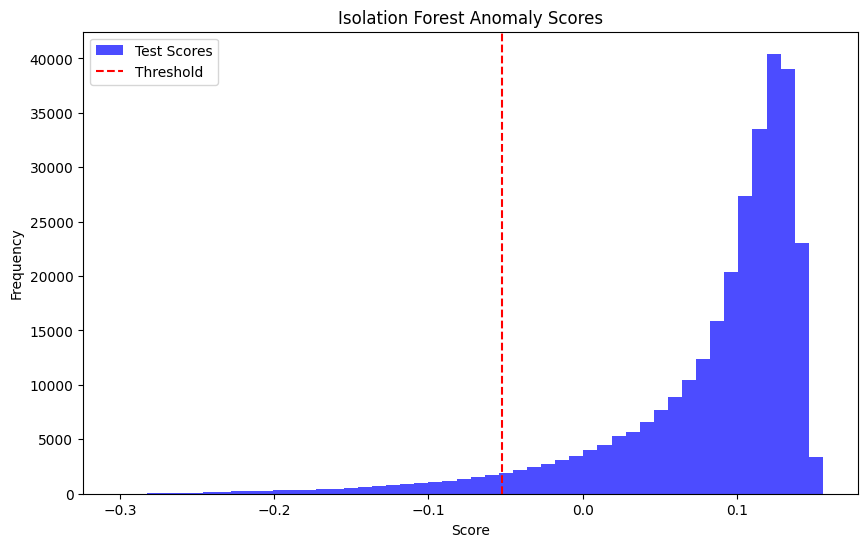

Anomaly Threshold: -0.05221039054348959
Number of Anomalies in Train Set: 59492
Number of Anomalies in Test Set: 14954
Train and test results saved successfully!


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Prepare the Dataset
# Assuming 'all_features' is already created from your preprocessed data

# Step 2: Split the Data
X_train, X_test = train_test_split(all_features, test_size=0.2, random_state=42, shuffle=True)

# Step 3: Normalize the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Define and Train the Isolation Forest Model
isolation_forest = IsolationForest(
    n_estimators=100,
    contamination=0.1,  # Adjust based on expected proportion of anomalies
    random_state=42,
    max_samples='auto',
    max_features=1.0
)
isolation_forest.fit(X_train_scaled)

# Step 5: Predict Anomalies
train_scores = isolation_forest.decision_function(X_train_scaled)
test_scores = isolation_forest.decision_function(X_test_scaled)

train_predictions = isolation_forest.predict(X_train_scaled)
test_predictions = isolation_forest.predict(X_test_scaled)

# Step 6: Threshold for Anomalies
anomaly_threshold = np.percentile(test_scores, 5)  # Lower scores are anomalies

train_anomalies = train_scores < anomaly_threshold
test_anomalies = test_scores < anomaly_threshold

# Step 7: Visualize Results
plt.figure(figsize=(10, 6))
plt.hist(test_scores, bins=50, color='blue', alpha=0.7, label='Test Scores')
plt.axvline(x=anomaly_threshold, color='red', linestyle='--', label='Threshold')
plt.title('Isolation Forest Anomaly Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Step 8: Output Results
print(f"Anomaly Threshold: {anomaly_threshold}")
print(f"Number of Anomalies in Train Set: {np.sum(train_anomalies)}")
print(f"Number of Anomalies in Test Set: {np.sum(test_anomalies)}")

# FIX: Separate results for train and test datasets
# Train results
train_results = pd.DataFrame({
    'train_scores': train_scores,
    'train_predictions': train_predictions,
    'train_anomalies': train_anomalies.astype(int)  # Convert boolean to integer (0/1)
})
train_results.to_csv('isolation_forest_train_results.csv', index=False)

# Test results
test_results = pd.DataFrame({
    'test_scores': test_scores,
    'test_predictions': test_predictions,
    'test_anomalies': test_anomalies.astype(int)  # Convert boolean to integer (0/1)
})
test_results.to_csv('isolation_forest_test_results.csv', index=False)

print("Train and test results saved successfully!")



--- Fine-Tuning with Contamination: 0.05 ---
Threshold Percentile: 1 | Anomaly Threshold: -0.10915471061973396
Train Anomalies: 11927 | Test Anomalies: 2991
Threshold Percentile: 5 | Anomaly Threshold: -0.00038035445719837146
Train Anomalies: 59492 | Test Anomalies: 14954
Threshold Percentile: 10 | Anomaly Threshold: 0.051214515647506655
Train Anomalies: 118687 | Test Anomalies: 29908

--- Fine-Tuning with Contamination: 0.1 ---
Threshold Percentile: 1 | Anomaly Threshold: -0.1609847467060252
Train Anomalies: 11927 | Test Anomalies: 2991
Threshold Percentile: 5 | Anomaly Threshold: -0.05221039054348959
Train Anomalies: 59492 | Test Anomalies: 14954
Threshold Percentile: 10 | Anomaly Threshold: -0.000615520438784566
Train Anomalies: 118687 | Test Anomalies: 29908

--- Fine-Tuning with Contamination: 0.15 ---
Threshold Percentile: 1 | Anomaly Threshold: -0.19084261644740913
Train Anomalies: 11927 | Test Anomalies: 2991
Threshold Percentile: 5 | Anomaly Threshold: -0.08206826028487353
Tr

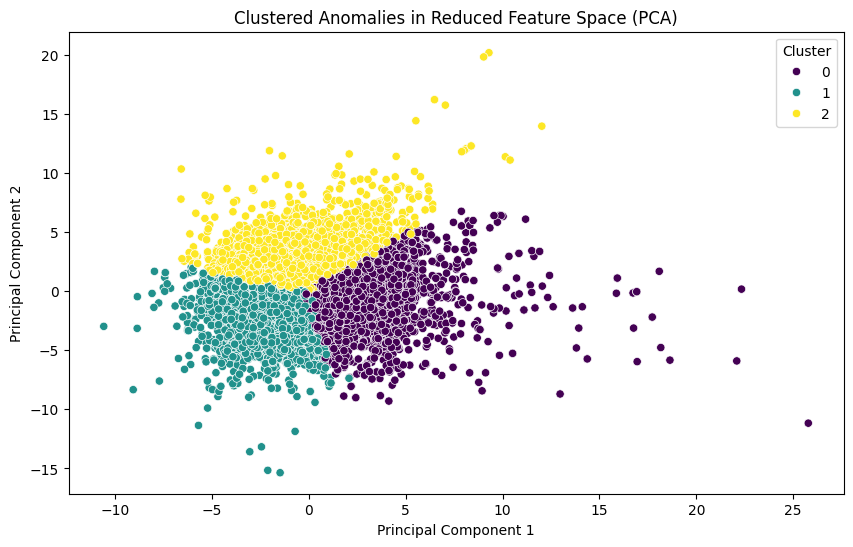

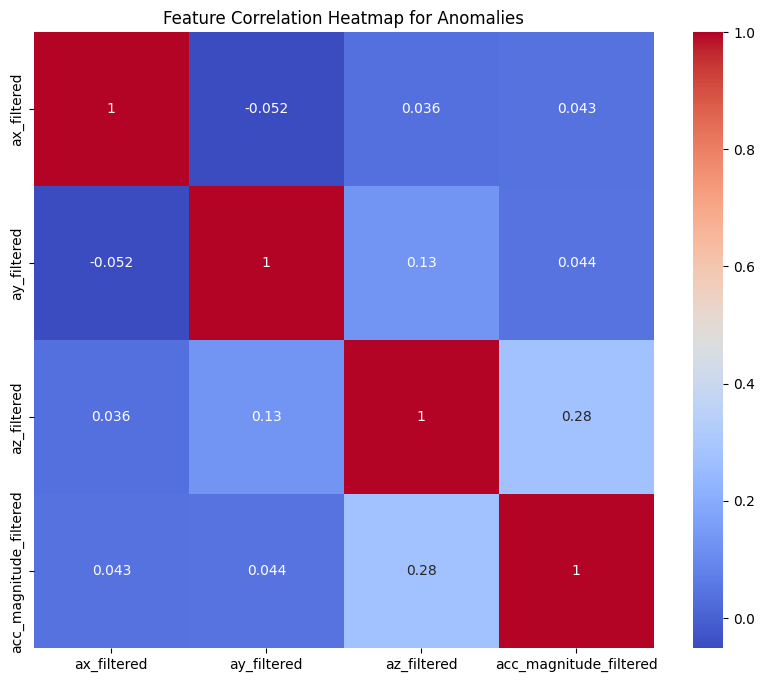

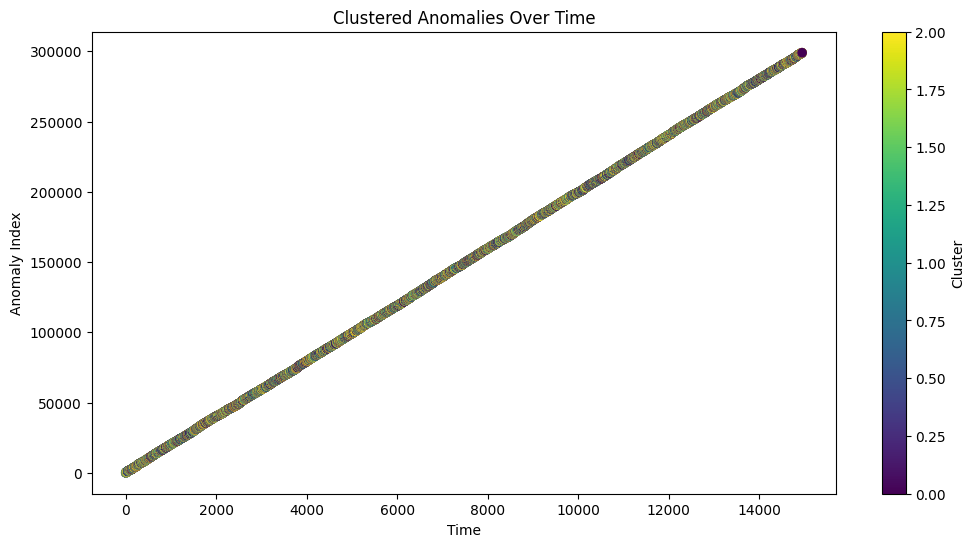

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the Dataset
# Assuming 'all_features' is already created from your preprocessed data

# Step 2: Split the Data
X_train, X_test = train_test_split(all_features, test_size=0.2, random_state=42, shuffle=True)

# Step 3: Normalize the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Define Function for Fine-Tuning the Model
def fine_tune_isolation_forest(X_train_scaled, X_test_scaled, contamination_values, threshold_percentiles):
    results = []
    best_test_anomalies = None  # Store best anomaly set

    for contamination in contamination_values:
        print(f"\n--- Fine-Tuning with Contamination: {contamination} ---")

        isolation_forest = IsolationForest(
            n_estimators=100,
            contamination=contamination,
            random_state=42,
            max_samples='auto',
            max_features=1.0
        )
        isolation_forest.fit(X_train_scaled)

        # Scores
        train_scores = isolation_forest.decision_function(X_train_scaled)
        test_scores = isolation_forest.decision_function(X_test_scaled)

        for percentile in threshold_percentiles:
            anomaly_threshold = np.percentile(test_scores, percentile)
            train_anomalies = train_scores < anomaly_threshold
            test_anomalies = test_scores < anomaly_threshold

            num_train_anomalies = np.sum(train_anomalies)
            num_test_anomalies = np.sum(test_anomalies)

            print(f"Threshold Percentile: {percentile} | Anomaly Threshold: {anomaly_threshold}")
            print(f"Train Anomalies: {num_train_anomalies} | Test Anomalies: {num_test_anomalies}")

            # Store results
            results.append({
                'contamination': contamination,
                'percentile': percentile,
                'threshold': anomaly_threshold,
                'train_anomalies': num_train_anomalies,
                'test_anomalies': num_test_anomalies
            })

            # Store the best anomaly set for further analysis
            if contamination == 0.1 and percentile == 5:
                best_test_anomalies = test_anomalies

    return results, best_test_anomalies

# Parameters for fine-tuning
contamination_values = [0.05, 0.1, 0.15]  # Test different contamination levels
threshold_percentiles = [1, 5, 10]  # Test different threshold percentiles

# Step 5: Fine-Tune the Isolation Forest Model
fine_tuning_results, test_anomalies = fine_tune_isolation_forest(X_train_scaled, X_test_scaled, contamination_values, threshold_percentiles)

# Convert results to DataFrame and save
fine_tuning_df = pd.DataFrame(fine_tuning_results)
fine_tuning_df.to_csv('fine_tuning_results.csv', index=False)

# Step 6: Perform Clustering on Anomalies
# Extract anomaly data points
test_anomalies_indices = np.where(test_anomalies)[0]
test_anomalies_data = X_test_scaled[test_anomalies_indices]

# Perform K-Means Clustering on detected anomalies
num_clusters = 3  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(test_anomalies_data)

# Add cluster labels to the anomaly dataset
anomaly_df = pd.DataFrame(test_anomalies_data, columns=['ax_filtered', 'ay_filtered', 'az_filtered', 'acc_magnitude_filtered'])
anomaly_df['Cluster'] = cluster_labels

# Save clustered anomalies
anomaly_df.to_csv('clustered_anomalies.csv', index=False)

# Step 7: Visualize Clustering Results Using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(test_anomalies_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=cluster_labels, palette='viridis')
plt.title("Clustered Anomalies in Reduced Feature Space (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Step 8: Feature Correlation Heatmap (Only for Anomalous Data)
plt.figure(figsize=(10, 8))
sns.heatmap(anomaly_df.drop(columns=['Cluster']).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap for Anomalies")
plt.show()

# Step 9: Visualize Clusters Over Time
timestamps = np.arange(len(test_anomalies_indices))  # Replace with actual timestamps if available
plt.figure(figsize=(12, 6))
plt.scatter(timestamps, test_anomalies_indices, c=cluster_labels, cmap='viridis', marker='o')
plt.title("Clustered Anomalies Over Time")
plt.xlabel("Time")
plt.ylabel("Anomaly Index")
plt.colorbar(label="Cluster")
plt.show()


Cluster Properties:

Cluster 0:
       ax_filtered  ay_filtered  az_filtered  acc_magnitude_filtered  \
count  5534.000000  5534.000000  5534.000000             5534.000000   
mean     -0.428821     1.579025     2.506812                3.212558   
std       2.066363     2.181789     1.788360                2.209329   
min     -11.599000    -7.261763    -3.447970                0.533921   
25%      -1.673805     0.009977     1.449175                1.968369   
50%      -0.668138     1.573323     2.540516                2.571476   
75%       0.793346     3.095038     3.397549                3.637304   
max       9.342060    16.827737    25.036328               35.113936   

       KMeans_Cluster  DBSCAN_Cluster  Hierarchical_Cluster  
count          5534.0     5534.000000           5534.000000  
mean              0.0        2.265269              0.050235  
std               0.0       13.835604              0.298207  
min               0.0       -1.000000              0.000000  
25%      

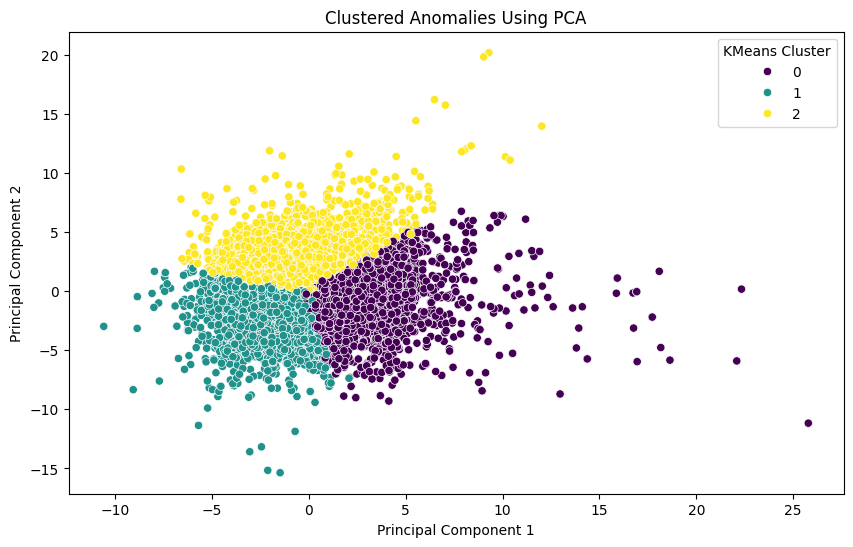

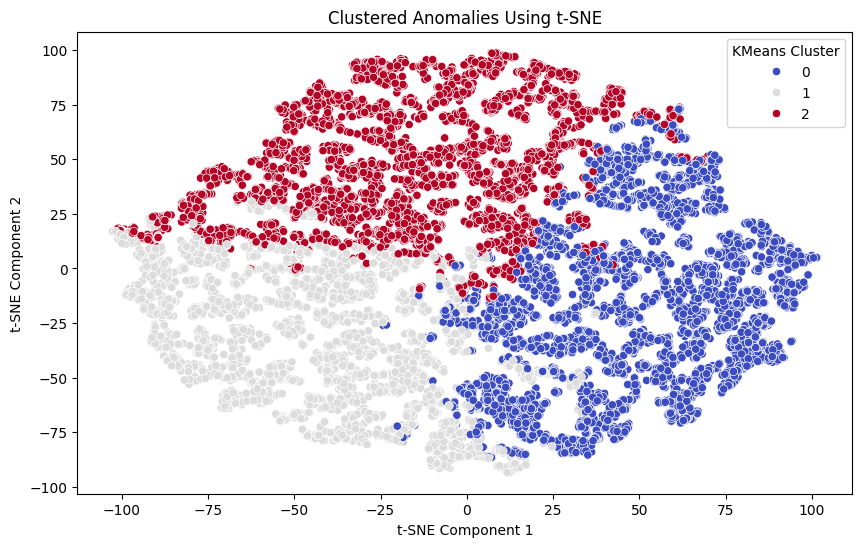

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


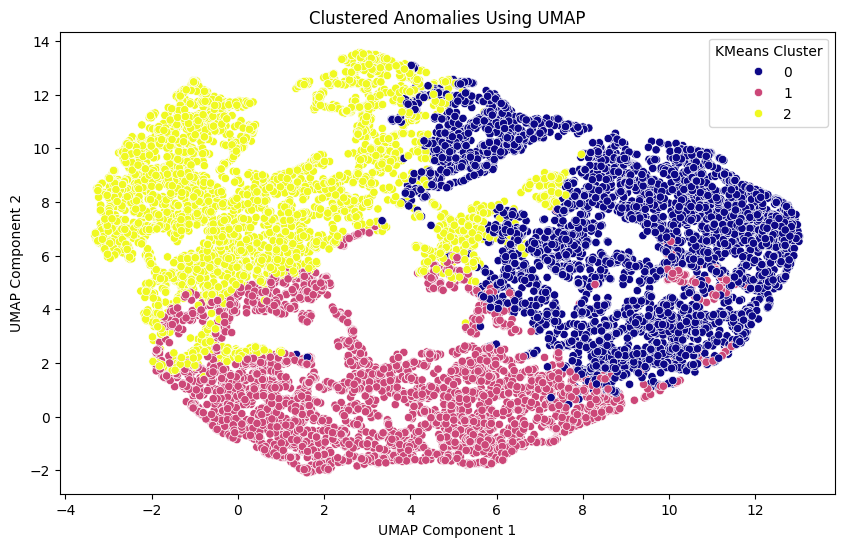

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the Dataset
X_train, X_test = train_test_split(all_features, test_size=0.2, random_state=42, shuffle=True)

# Step 2: Normalize the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Fine-Tune the Isolation Forest Model
isolation_forest = IsolationForest(
    n_estimators=100,
    contamination=0.1,  # Adjusted contamination level
    random_state=42,
    max_samples='auto',
    max_features=1.0
)
isolation_forest.fit(X_train_scaled)

# Get anomaly scores
test_scores = isolation_forest.decision_function(X_test_scaled)

# Set anomaly threshold at 5th percentile
anomaly_threshold = np.percentile(test_scores, 5)
test_anomalies = test_scores < anomaly_threshold

# Extract anomaly data points
test_anomalies_indices = np.where(test_anomalies)[0]
test_anomalies_data = X_test_scaled[test_anomalies_indices]

# Step 4: Perform K-Means Clustering on Anomalies
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(test_anomalies_data)

# Save clustered anomalies
anomaly_df = pd.DataFrame(test_anomalies_data, columns=['ax_filtered', 'ay_filtered', 'az_filtered', 'acc_magnitude_filtered'])
anomaly_df['KMeans_Cluster'] = kmeans_labels

# Step 5: Alternative Clustering Techniques - DBSCAN & Hierarchical Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(test_anomalies_data)

hierarchical = AgglomerativeClustering(n_clusters=num_clusters)
hierarchical_labels = hierarchical.fit_predict(test_anomalies_data)

# Add results to the dataframe
anomaly_df['DBSCAN_Cluster'] = dbscan_labels
anomaly_df['Hierarchical_Cluster'] = hierarchical_labels

# Save the dataframe
anomaly_df.to_csv('clustering_results.csv', index=False)

# Step 6: Analyze Cluster Properties
print("Cluster Properties:")
for cluster in range(num_clusters):
    cluster_data = anomaly_df[anomaly_df['KMeans_Cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(cluster_data.describe())  # Statistical analysis of the cluster

# Step 7: Visualize Clustering Results Using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(test_anomalies_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=kmeans_labels, palette='viridis')
plt.title("Clustered Anomalies Using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="KMeans Cluster")
plt.show()

# Step 8: Advanced Visualization with t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(test_anomalies_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=kmeans_labels, palette='coolwarm')
plt.title("Clustered Anomalies Using t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="KMeans Cluster")
plt.show()

# Step 9: Advanced Visualization with UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_features = umap_reducer.fit_transform(test_anomalies_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_features[:, 0], y=umap_features[:, 1], hue=kmeans_labels, palette='plasma')
plt.title("Clustered Anomalies Using UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend(title="KMeans Cluster")
plt.show()


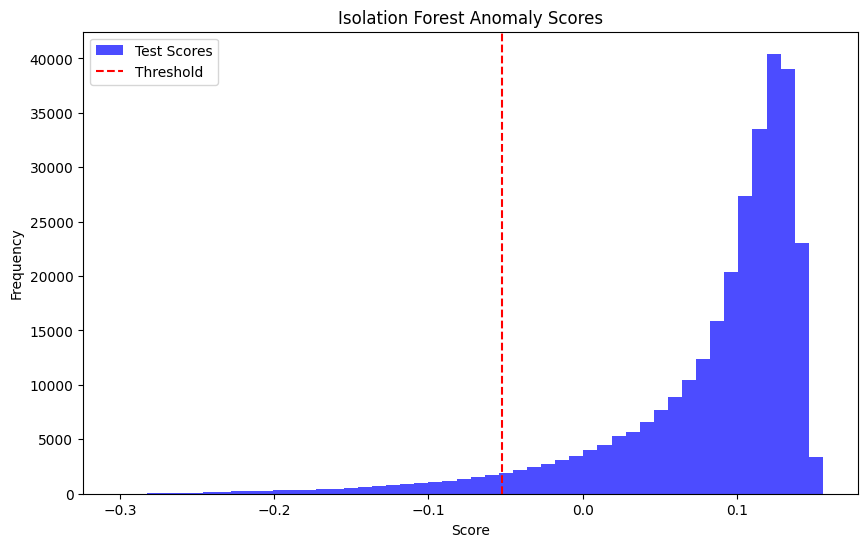

Anomaly Threshold: -0.05221039054348959
Number of Anomalies in Train Set: 59492
Number of Anomalies in Test Set: 14954


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Prepare the Dataset
# Assuming 'all_features' is already created from your preprocessed data
# If not, preprocess and load your features similar to the autoencoder workflow

# Step 2: Split the Data
X_train, X_test = train_test_split(all_features, test_size=0.2, random_state=42, shuffle=True)

# Step 3: Normalize the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Define and Train the Isolation Forest Model
# Parameters can be adjusted for better performance
isolation_forest = IsolationForest(
    n_estimators=100,
    contamination=0.1,  # Adjust based on expected proportion of anomalies
    random_state=42,
    max_samples='auto',
    max_features=1.0
)
isolation_forest.fit(X_train_scaled)

# Step 5: Predict Anomalies
# Prediction scores: Negative scores indicate anomalies
train_scores = isolation_forest.decision_function(X_train_scaled)
test_scores = isolation_forest.decision_function(X_test_scaled)

# Predict anomalies (-1 for anomaly, 1 for normal)
train_predictions = isolation_forest.predict(X_train_scaled)
test_predictions = isolation_forest.predict(X_test_scaled)

# Step 6: Threshold for Anomalies
# Identify anomalies by setting a threshold (e.g., 5th percentile of scores)
anomaly_threshold = np.percentile(test_scores, 5)  # Lower scores are anomalies

# Flag anomalies based on threshold
train_anomalies = train_scores < anomaly_threshold
test_anomalies = test_scores < anomaly_threshold

# Step 7: Visualize Results
plt.figure(figsize=(10, 6))
plt.hist(test_scores, bins=50, color='blue', alpha=0.7, label='Test Scores')
plt.axvline(x=anomaly_threshold, color='red', linestyle='--', label='Threshold')
plt.title('Isolation Forest Anomaly Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Step 8: Output Results
print(f"Anomaly Threshold: {anomaly_threshold}")
print(f"Number of Anomalies in Train Set: {np.sum(train_anomalies)}")
print(f"Number of Anomalies in Test Set: {np.sum(test_anomalies)}")

# Optional: Save results for further analysis
results = {
    'train_scores': train_scores,
    'test_scores': test_scores,
    'train_predictions': train_predictions,
    'test_predictions': test_predictions,
    'train_anomalies': train_anomalies,
    'test_anomalies': test_anomalies
}
# pd.DataFrame(results).to_csv('isolation_forest_results.csv', index=False)


In [ ]:
pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.4 MB/s eta 0:00:00


In [ ]:
for key, value in results.items():
    print(f"{key}: {len(value)}")

train_scores: 1196320
test_scores: 299080
train_predictions: 1196320
test_predictions: 299080
train_anomalies: 1196320
test_anomalies: 299080
